# Проект для «Викишоп» с Bert

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

**Описание данных**
<ul>
<li>text-текст комментария
<li>toxic-целевой признак
</ul>

## Содержание
* [Загрузка библиотек](#chapter1)
* [Загрузка данных](#chapter2)
* [Исследование и предобработка данных](#chapter3)
* [Обучение](#chapter4)
* [Выбор модели](#chapter5)
* [Вывод](#chapter6)
* [Примечание](#chapter6)

## Загрузка библиотек <a class="anchor" id="chapter1"></a>

In [23]:
%pip install sentence_transformers


[notice] A new release of pip available: 22.3.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [24]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import re
import string
from sentence_transformers import SentenceTransformer
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,f1_score,roc_auc_score
from catboost import CatBoostClassifier
from torch import nn
import torch
from torch.utils.data import TensorDataset,DataLoader
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
from sklearn.utils import resample
from nltk import pos_tag
from nltk.corpus import wordnet
from sklearn.metrics import confusion_matrix
from collections import Counter

## Загрузка данных <a class="anchor" id="chapter2"></a>

In [25]:
df = pd.read_csv('toxic_comments.csv',index_col=0)

In [26]:
df

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
...,...,...
159446,""":::::And for the second time of asking, when ...",0
159447,You should be ashamed of yourself \n\nThat is ...,0
159448,"Spitzer \n\nUmm, theres no actual article for ...",0
159449,And it looks like it was actually you who put ...,0


**Описание данных**
<ul>
<li>text-текст комментария
<li>toxic-целевой признак
</ul>
Количество объектов: 159 292

## Исследование и предобработка данных <a class="anchor" id="chapter3"></a>

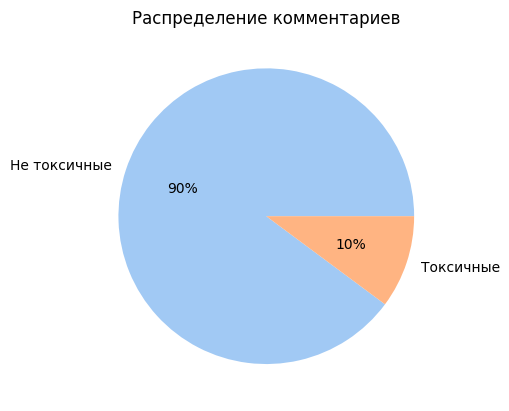

In [27]:
colors = sns.color_palette('pastel')[0:5]
plt.pie(x=df.groupby(by='toxic').aggregate(lambda p:len(p)/len(df)).values.flatten(), labels = ['Не токсичные','Токсичные'],colors=colors, autopct='%.0f%%');
plt.title('Распределение комментариев');

В данных присутсвует явный дисбаланс классов: доля "токсичных" комментариев - 10%. При дальнейшем построении моделей будем учитывать это.

In [28]:
df['text']

0         Explanation\nWhy the edits made under my usern...
1         D'aww! He matches this background colour I'm s...
2         Hey man, I'm really not trying to edit war. It...
3         "\nMore\nI can't make any real suggestions on ...
4         You, sir, are my hero. Any chance you remember...
                                ...                        
159446    ":::::And for the second time of asking, when ...
159447    You should be ashamed of yourself \n\nThat is ...
159448    Spitzer \n\nUmm, theres no actual article for ...
159449    And it looks like it was actually you who put ...
159450    "\nAnd ... I really don't think you understand...
Name: text, Length: 159292, dtype: object

В самих комментариях помимо текста присутсвует множество информации, которая будет мешать при обучении модели. Для устранения этой проблемы почистим текст

In [29]:
def clean_text(text):
    
    sample = text
    sample = " ".join([x.lower() for x in sample.split()])
    sample = re.sub(r"\S*https?:\S*", '', sample) #links and urls
    sample = re.sub('\[.*?\]', '', sample) #text between [square brackets]
    sample = re.sub('\(.*?\)', '', sample) #text between (parenthesis)
    sample = re.sub('#', ' ', sample) #remove hashtags
    sample = ' '.join([x for x in sample.split() if not x.startswith('@')]) # remove mentions with @
    sample = re.sub('[%s]' % re.escape(string.punctuation), ' ', sample) #punctuations
    sample = re.sub('\w*\d\w', '', sample) #digits with trailing or preceeding text
    sample = re.sub(r'\n', ' ', sample) #new line character
    sample = re.sub(r'\\n', ' ', sample) #new line character
    sample = re.sub("[''""...“”‘’…]", '', sample) #list of quotation marks
    sample = " ".join(x.strip() for x in sample.split()) #strips whitespace
    sample = re.sub(r', /<[^>]+>/', '', sample)    #HTML attributes
    
    sample = ' '.join(list(filter(lambda ele: re.search("[a-zA-Z\s]+", ele) is not None, sample.split()))) #languages other than english
    
    sample = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE).sub(r'', sample) #emojis and symbols
    sample = sample.strip()
    sample = " ".join([x.strip() for x in sample.split()])
    
    return sample

In [30]:
df['clean_text'] = df['text'].apply(clean_text) 

In [31]:
df

,text,toxic,clean_text
0,Explanation\nWhy the edits made under my usern...,0,explanation why the edits made under my userna...
1,D'aww! He matches this background colour I'm s...,0,d aww he matches this background colour i m se...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man i m really not trying to edit war it s...
3,"""\nMore\nI can't make any real suggestions on ...",0,more i can t make any real suggestions on impr...
4,"You, sir, are my hero. Any chance you remember...",0,you sir are my hero any chance you remember wh...
...,...,...,...
159446,""":::::And for the second time of asking, when ...",0,and for the second time of asking when your vi...
159447,You should be ashamed of yourself \n\nThat is ...,0,you should be ashamed of yourself that is a ho...
159448,"Spitzer \n\nUmm, theres no actual article for ...",0,spitzer umm theres no actual article for prost...
159449,And it looks like it was actually you who put ...,0,and it looks like it was actually you who put ...


In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Skoolz\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Skoolz\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Skoolz\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

Сделаем токенизацию и лемматизацию текста

In [ ]:
tokenizer = WordNetLemmatizer()

In [ ]:
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

def lemmatize_words(words):
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = []

    for word, pos in pos_tag(words):
        wordnet_pos = get_wordnet_pos(pos) or wordnet.NOUN
        lemmatized_words.append(lemmatizer.lemmatize(word, pos=wordnet_pos))

    return lemmatized_words

In [ ]:
def convert_text(text):
    tokens = word_tokenize(text)
    tokens = [token for token in tokens if token not in stopwords.words('english') and token not in string.punctuation]
    return ' '.join(lemmatize_words(tokens))

In [ ]:
df['token_text'] = df['clean_text'].apply(convert_text)

In [ ]:
df

,text,toxic,clean_text,token_text
0,Explanation\nWhy the edits made under my usern...,0,explanation why the edits made under my userna...,explanation edits make username hardcore metal...
1,D'aww! He matches this background colour I'm s...,0,d aww he matches this background colour i m se...,aww match background colour seemingly stuck th...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man i m really not trying to edit war it s...,hey man really try edit war guy constantly rem...
3,"""\nMore\nI can't make any real suggestions on ...",0,more i can t make any real suggestions on impr...,make real suggestion improvement wonder sectio...
4,"You, sir, are my hero. Any chance you remember...",0,you sir are my hero any chance you remember wh...,sir hero chance remember page
...,...,...,...,...
159446,""":::::And for the second time of asking, when ...",0,and for the second time of asking when your vi...,second time ask view completely contradict cov...
159447,You should be ashamed of yourself \n\nThat is ...,0,you should be ashamed of yourself that is a ho...,ashamed horrible thing put talk page
159448,"Spitzer \n\nUmm, theres no actual article for ...",0,spitzer umm theres no actual article for prost...,spitzer umm there actual article prostitution ...
159449,And it looks like it was actually you who put ...,0,and it looks like it was actually you who put ...,look like actually put speedy first version de...


In [ ]:
txts = [
    df.query('toxic==0')['token_text'],
    df.query('toxic==1')['token_text']
]

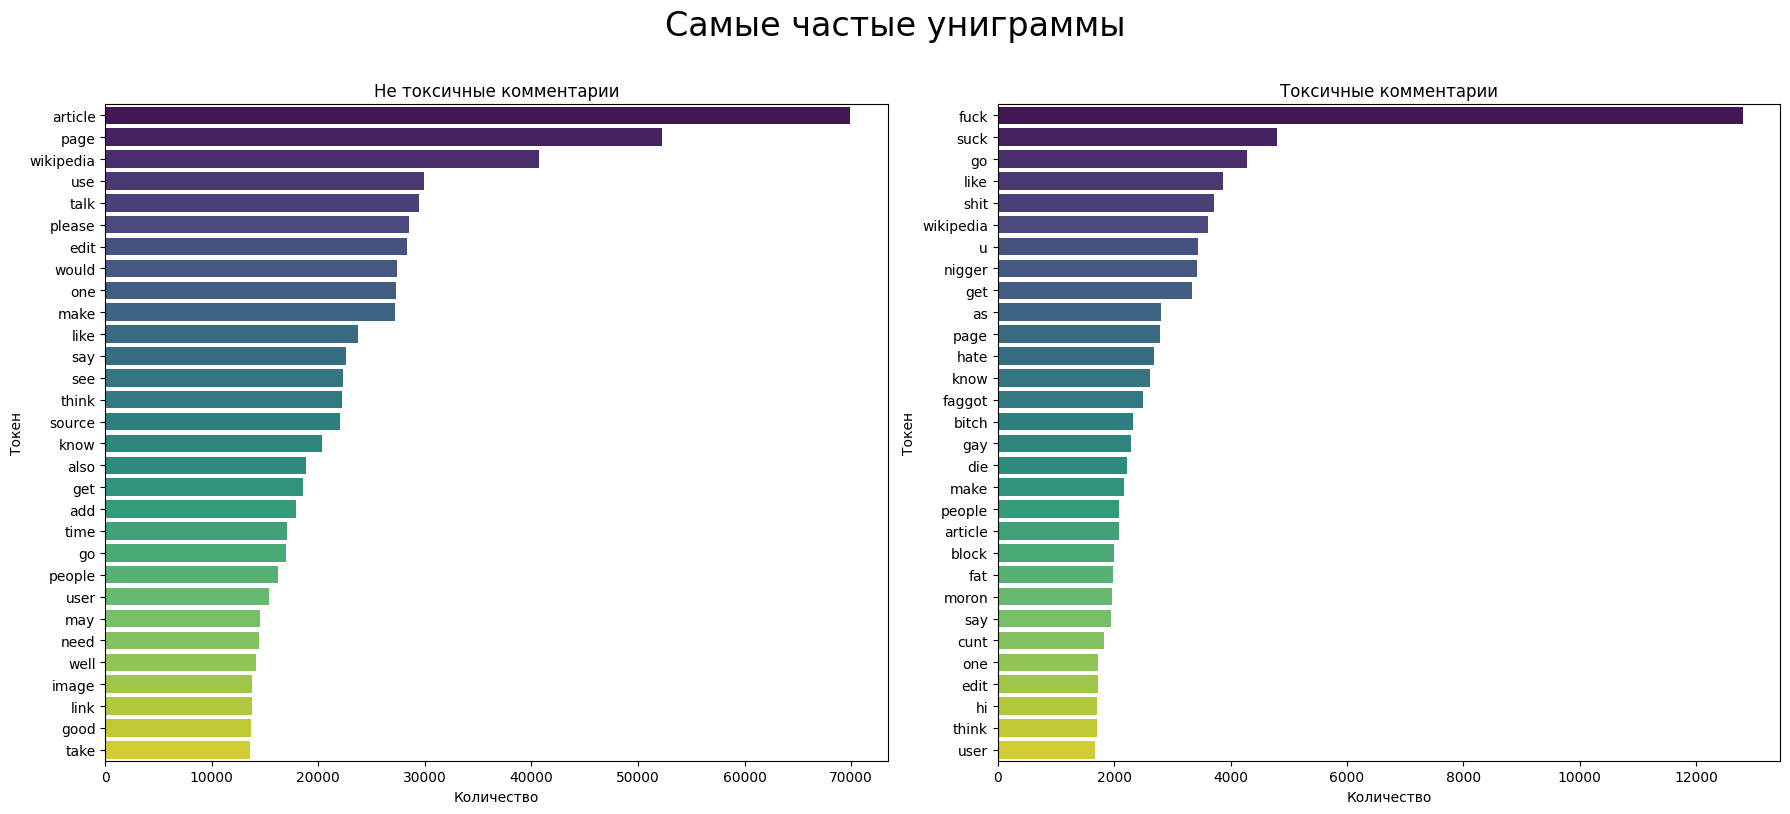

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
axes = axes.flatten()
most_words = []
for i, j in zip(txts, axes):

    new = i.str.split()
    new = new.values.tolist()
    corpus = [word for i in new for word in i]

    counter = Counter(corpus)
    most = counter.most_common()
    x, y = [], []
    for word, count in most[:30]:
        x.append(word)
        y.append(count)
    most_words.append(list(zip(*most))[0])

    sns.barplot(x=y, y=x, palette="viridis", ax=j)
axes[0].set_title('Не токсичные комментарии')

axes[1].set_title('Токсичные комментарии')
axes[0].set_xlabel('Количество')
axes[0].set_ylabel('Токен')
axes[1].set_xlabel('Количество')
axes[1].set_ylabel('Токен')

fig.suptitle('Самые частые униграммы', fontsize=24, va='baseline')
plt.tight_layout()

In [ ]:
def simmilarity(most_words,k):
    return sum([1 for i in most_words[0][:k] if i in most_words[1][:k]])/len(most_words[0][:k])

In [ ]:
simmilarity(most_words,10)

0.1

In [ ]:
simmilarity(most_words,5)

0.0

Исходя из графика использования разлиных токенов в комментариях, видна разница между токсичными и не токсичными комментариями. Так в 10 самых часто встречаемых токенов, количество токенов, которые встречаются в обеих группах (токсичные и не токсичные) - 1, а среди 5 самых встречаемых вообще 0

### Вывод

В данных присутсвует явный дисбаланс классов: доля "токсичных" комментариев - 10%. При дальнейшем построении моделей будем учитывать это.</br>
Была проведена предобработка данных: текст был очищен от лишних символов. Также была проведена лемматизация и токенизация текста.</br>
Исходя из графика использования разлиных токенов в комментариях, видна разница между токсичными и не токсичными комментариями. Так в 10 самых часто встречаемых токенов, количество токенов, которые встречаются в обеих группах (токсичные и не токсичные) - 1, а среди 5 самых встречаемых вообще 0

## Обучение <a class="anchor" id="chapter4"></a>

### TF-IDF

Исходя из полученной ранее информации, можн предположить, что основываясь на появлении слов в тексте, уже можно получить хороший результат в классификации. Поэтому в качестве baseline модели используем tf-idf с логистической регрессией

In [20]:
features = list(df['token_text'])

In [14]:
target = df['toxic'].to_numpy()

In [24]:
features_train,features_test,target_train,target_test = train_test_split(features,target,test_size=0.2,random_state=12345)

In [25]:
features_test,features_valid,target_test,target_valid = train_test_split(features_test,target_test,test_size=0.5,random_state=12345)

In [27]:
vectorizer = TfidfVectorizer()

features_train = vectorizer.fit_transform(features_train)
features_valid= vectorizer.transform(features_valid)

#### LogisticRegression

In [28]:
model = LogisticRegression(solver='liblinear')

In [29]:
model.fit(features_train,target_train)

LogisticRegression(solver='liblinear')

In [32]:
print(f1_score(target_train,model.predict(features_train)))

0.7667419458911371


In [31]:
print(f1_score(target_valid,model.predict(features_valid)))

0.7521241226449945


Учтем дисбаланс классов

In [35]:
best_thr = 0
best_score = 0
for thr in np.arange(0.1,0.5,0.05):
    score = f1_score(target_valid,model.predict_proba(features_valid)[:,1]>thr)
    if(score>best_score):
        best_score=score
        best_thr=thr

In [38]:
print(f'{thr:.2}:{best_score:.2}')

0.45:0.79


f1 на тренировочной выборке: 0.77</br>
f1 на валидационной выборке: 0.79

### Использование embedding модели без обучения (см Примечание)

Попробуем использовать готовую обученную модель для извелечения признаков. Для этого используем библиотеку SentenceTransformers. Для получения признаков используем модель: `all-distilroberta-v1`

Загрузим полученные признаки от модели

In [32]:
with open('features.pickle','rb') as output:
    features = pickle.load(output)

In [33]:
features.shape

(159292, 768)

In [34]:
features_train,features_test,target_train,target_test = train_test_split(features,target,test_size=0.2,random_state=12345)
features_test,features_valid,target_test,target_valid = train_test_split(features_test,target_test,test_size=0.5,random_state=12345)

In [35]:
features_test_tn = torch.tensor(features_test)

#### LogisticRegression

In [49]:
model = LogisticRegression(solver='liblinear')

In [50]:
model.fit(features_train,target_train)

LogisticRegression(solver='liblinear')

In [51]:
print(f1_score(target_train,model.predict(features_train)))

0.7401236462489587


In [52]:
print(f1_score(target_valid,model.predict(features_valid)))

0.7228915662650601


In [53]:
best_thr = 0
best_score = 0
for thr in np.arange(0.1,0.5,0.05):
    score = f1_score(target_valid,model.predict_proba(features_valid)[:,1]>thr)
    if(score>best_score):
        best_score=score
        best_thr=thr

In [54]:
print(f'{thr:.2}:{best_score:.2}')

0.45:0.75


f1 на тренировочной выборке: 0.74</br>
f1 на валидационной выборке: 0.75

#### CatBoostClassifier

In [60]:
model = CatBoostClassifier(iterations=1000,random_state=12345)

In [61]:
model.fit(features_train,target_train)

Learning rate set to 0.081637
0:	learn: 0.5973517	total: 173ms	remaining: 2m 52s
1:	learn: 0.5187675	total: 331ms	remaining: 2m 45s
2:	learn: 0.4563965	total: 491ms	remaining: 2m 43s
3:	learn: 0.4107674	total: 647ms	remaining: 2m 41s
4:	learn: 0.3716888	total: 800ms	remaining: 2m 39s
5:	learn: 0.3412925	total: 956ms	remaining: 2m 38s
6:	learn: 0.3166185	total: 1.11s	remaining: 2m 37s
7:	learn: 0.2970755	total: 1.28s	remaining: 2m 38s
8:	learn: 0.2822311	total: 1.46s	remaining: 2m 41s
9:	learn: 0.2688913	total: 1.62s	remaining: 2m 40s
10:	learn: 0.2573813	total: 1.78s	remaining: 2m 39s
11:	learn: 0.2478307	total: 1.94s	remaining: 2m 39s
12:	learn: 0.2398366	total: 2.09s	remaining: 2m 39s
13:	learn: 0.2333702	total: 2.25s	remaining: 2m 38s
14:	learn: 0.2271846	total: 2.4s	remaining: 2m 37s
15:	learn: 0.2225618	total: 2.56s	remaining: 2m 37s
16:	learn: 0.2173920	total: 2.71s	remaining: 2m 36s
17:	learn: 0.2135219	total: 2.86s	remaining: 2m 36s
18:	learn: 0.2100310	total: 3.01s	remaining: 

In [62]:
print(f1_score(target_train,model.predict(features_train)))

0.8695615227736234


In [63]:
print(f1_score(target_valid,model.predict(features_valid)))

0.7027220630372493


In [64]:
best_thr = 0
best_score = 0
for thr in np.arange(0.1,0.5,0.05):
    score = f1_score(target_valid,model.predict_proba(features_valid)[:,1]>thr)
    if(score>best_score):
        best_score=score
        best_thr=thr

In [65]:
print(f'{thr:.2}:{best_score:.2}')

0.45:0.72


f1 на тренировочной выборке: 0.87</br>
f1 на валидационной выборке: 0.72

#### NeuralNetwork

In [36]:
def train_model(model, optimizer, loss_fn, train_loader, val_loader, epochs):

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for batch in train_loader:
            inputs, targets = batch
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, targets)
            total_loss += loss.item()
            loss.backward()
            optimizer.step()

        avg_train_loss = total_loss / len(train_loader)
        print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_train_loss}')

        # Оценка на валидационном наборе
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                inputs, targets = batch
                outputs = model(inputs)
                loss = loss_fn(outputs, targets)
                val_loss += loss.item()
        avg_val_loss = val_loss / len(val_loader)
        print(f'Validation Loss: {avg_val_loss}')

    return model

In [37]:
train_dataset = TensorDataset(torch.tensor(features_train,dtype=torch.float32),torch.tensor(target_train,dtype=torch.float32).view(-1,1))
val_dataset = TensorDataset(torch.tensor(features_valid,dtype=torch.float32),torch.tensor(target_valid,dtype=torch.float32).view(-1,1))
train_dataloader = DataLoader(train_dataset,batch_size=1500,shuffle=True)
val_dataloader = DataLoader(val_dataset,batch_size=1000,shuffle=True)

In [38]:
model = nn.Sequential(
    nn.Linear(features.shape[-1],100),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(100,1),
    nn.Sigmoid()
)

Учтем дисбаланс классов

In [39]:
class_counts = [len(target_train)-sum(target_train),sum(target_train)]
total_count = len(target_train)
class_weights = [total_count / class_count for class_count in class_counts]

In [40]:
class_weights = torch.tensor(class_weights,dtype=torch.float32)

In [41]:
class_weights

tensor([1.1132, 9.8358])

In [42]:
loss_fn = nn.BCELoss(reduction='none')

In [43]:
def loss_weight_fn(y_pred,y_true):
    loss_raw = loss_fn(y_pred,y_true)
    weight = torch.ones_like(loss_raw)
    weight[y_true==1.] = class_weights[1]
    return (loss_raw*weight).mean()

In [44]:
model = train_model(model,optimizer=torch.optim.AdamW(model.parameters(),lr=0.001,weight_decay=0.004),loss_fn=loss_weight_fn,train_loader=train_dataloader,val_loader=val_dataloader,epochs=50)

Epoch 1/50, Loss: 0.8561941094258252
Validation Loss: 0.595817044377327
Epoch 2/50, Loss: 0.5405888957135817
Validation Loss: 0.5374625772237778
Epoch 3/50, Loss: 0.5069291886161356
Validation Loss: 0.5209423247724771
Epoch 4/50, Loss: 0.4915771659682779
Validation Loss: 0.5104319024831057
Epoch 5/50, Loss: 0.4828691054792965
Validation Loss: 0.5051277447491884
Epoch 6/50, Loss: 0.47584792130133685
Validation Loss: 0.5047872215509415
Epoch 7/50, Loss: 0.47102815543904025
Validation Loss: 0.4976654276251793
Epoch 8/50, Loss: 0.46614699398770054
Validation Loss: 0.4968165308237076
Epoch 9/50, Loss: 0.4642227242974674
Validation Loss: 0.49186813458800316
Epoch 10/50, Loss: 0.45959604627945844
Validation Loss: 0.4910096898674965
Epoch 11/50, Loss: 0.45687902710017037
Validation Loss: 0.4915119055658579
Epoch 12/50, Loss: 0.4539561194532058
Validation Loss: 0.4892309866845608
Epoch 13/50, Loss: 0.4508354860193589
Validation Loss: 0.4877398610115051
Epoch 14/50, Loss: 0.44832354082780723
Val

In [45]:
with torch.no_grad():
    model.eval()
    preds = model.forward(torch.tensor(features_train))
    preds = preds.numpy()
    preds = np.where(preds>=0.5,1,0)
    preds = preds.squeeze(-1)
    print(f1_score(target_train,preds))

0.7102078362606721


In [46]:
with torch.no_grad():
    best_score = 0
    best_thr = 0
    model.eval()
    preds = model.forward(torch.tensor(features_valid))
    preds_np = preds.numpy()
    for thr in np.arange(0.7,0.95,0.025):
        preds_thr = np.where(preds_np>=thr,1,0)
        preds_thr = preds_thr.squeeze(-1)
        score = f1_score(target_valid,preds_thr)
        if(score>best_score):
            best_score = score
            best_thr = thr

In [47]:
print(f'{thr:.2}:{best_score:.2}')

0.93:0.76


f1 на тренировочной выборке: 0.71</br>
f1 на валидационной выборке: 0.76

### Использование embedding с обучением модели (см Примечание)

Теперь попробуем обучать саму embedding модель. В качестве предобученной модели используем Bert, добавив к ней линейный слой для классификации

Загрузим полученные предсказания от модели

In [9]:
with open('preds','rb') as output:
    preds_lab = pickle.load(output)

In [14]:
target_train,target_test = train_test_split(target,test_size=0.2,random_state=12345)
target_test,target_valid = train_test_split(target_test,test_size=0.5,random_state=12345)

In [10]:
preds_lab_train,preds_lab_test = train_test_split(preds_lab,test_size=0.2,random_state=12345)
preds_lab_test,preds_lab_valid = train_test_split(preds_lab_test,test_size=0.5,random_state=12345)

In [11]:
preds_lab.shape

(159292,)

In [12]:
preds_lab_valid.shape

(15930,)

In [15]:
print('f1 на тренировочной выборке:',f1_score(target_train,preds_lab_train))

f1 на тренировочной выборке: 0.9298176981456849


In [16]:
print('f1 на валидационной выборке:',f1_score(target_valid,preds_lab_valid))

f1 на валидационной выборке: 0.8274095421069485


f1 на тренировочной выборке: 0.93</br>
f1 на валидационной выборке: 0.83

## Выбор модели <a class="anchor" id="chapter5"></a>

Исходя из результатов, лучшая модель - Bert с дополнительным линейным слоем на выходе</br>
f1 на тренировочной выборке: 0.93</br>
f1 на валидационной выборке: 0.83

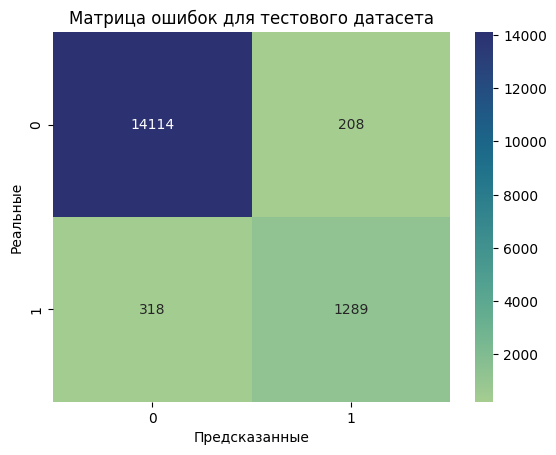

In [22]:
sns.heatmap(confusion_matrix(target_test,preds_lab_test),annot=True,fmt='g',cmap="crest").set(title='Матрица ошибок для тестового датасета',ylabel='Реальные',xlabel='Предсказанные');

In [66]:
print('f1:',f1_score(target_test,preds_lab_test))
print('accuracy:',accuracy_score(target_test,preds_lab_test))
print('auc-roc:',roc_auc_score(target_test,preds_lab_test))

f1: 0.8305412371134022
accuracy: 0.9669784669470777
auc-roc: 0.8937963161621753


### Вывод

Исходя из результатов, лучшая модель - Bert с дополнительным линейным слоем на выходе</br>
f1 на тренировочной выборке: 0.93</br>
f1 на валидационной выборке: 0.83</br>
f1 на тестовой выборке: 0.83
accuracy: 0.97</br>
auc-roc: 0.89</br>

## Вывод <a class="anchor" id="chapter7"></a>

Исходя из результатов, лучшая модель - Bert с дополнительным линейным слоем на выходе</br>
f1 на тренировочной выборке: 0.93</br>
f1 на валидационной выборке: 0.83</br>
f1 на тестовой выборке: 0.83</br>
accuracy: 0.97</br>
auc-roc: 0.89</br>

Полученное значение метрики f1 на тестовой выборке = 0.83 превышает значение 0.75, следовательно модель соответствует требованию заказчика.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Модели обучены
- [x]  Значение метрики *F1* не меньше 0.75
- [x]  Выводы написаны

## Примечание <a class="anchor" id="chapter6"></a>

Данный код запускался в отдельных блокнотах, поэтому не был включен в основую часть

### Получение признаков с использованием обученной модели и библиотеки sentence_transformers

In [ ]:
text = list(df['token_text'])
model = SentenceTransformer("sentence-transformers/all-distilroberta-v1",device='cuda')
features = model.encode(text,batch_size=300,show_progress_bar=True,convert_to_numpy=True)
with open('features','wb') as output:
  pickle.dump(features,output)

### Fine-tuning Bert и сохранение предсказний для датасета

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
texts = list(df['token_text'])
texts_train,texts_test,targets_train,targets_test = train_test_split(texts,target,test_size=0.2,random_state=12345)
train_encodings = tokenizer(texts_train, truncation=True, padding=True)
val_encodings = tokenizer(texts_test, truncation=True, padding=True)
class BDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)
train_dataset = BDataset(train_encodings, targets_train)
val_dataset = BDataset(val_encodings,targets_test)
from transformers import DistilBertForSequenceClassification, Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir='./results',   
    num_train_epochs=3,             
    per_device_train_batch_size=100, 
    per_device_eval_batch_size=100,  
    warmup_steps=500,              
    weight_decay=0.01,             
    logging_dir='./logs',       
    logging_steps=10,
    fp16=True,
    save_total_limit=1
)

model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased")

trainer = Trainer(
    model=model,                      
    args=training_args,                  
    train_dataset=train_dataset,    
    eval_dataset=val_dataset            
)

trainer.train()

model = DistilBertForSequenceClassification.from_pretrained('results/checkpoint-2500')
tokenizer_kwargs = {'padding':True,'truncation':True}

classifier = pipeline("sentiment-analysis", model=model,tokenizer=tokenizer,device=0)
preds = classifier(texts,**tokenizer_kwargs)

preds_lab = [p['label'] for p in preds]
preds_lab = [s[-1] for s in preds_lab]
preds_lab = [int(s) for s in preds_lab]
preds_lab = np.array(preds_lab)

with open('preds','wb') as output:
  pickle.dump(preds_lab,output)